In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
%cd ..
%pwd

/home/markus/Documents/regression-prediction


'/home/markus/Documents/regression-prediction'

In [2]:
from experiments.modeleval_utils import *

/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
def fit_best_model(model, data, feature_type, target, scoring):
    X, y, features = data_map[feature_type][data](target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    pipeline, best_params, best_result = get_pipeline(data, feature_type, target, scoring, model)
    pipeline.fit(X_train, y_train)
    t, f1 = get_best_f1_threshold(pipeline, X_train, y_train)
    return pipeline, t

In [4]:
def predict_at_threshold(clf, X, t):
    y_score = get_y_score(clf, X)
    return (y_score >= t).astype(int)

In [5]:
datas = {
    'szz_traditional': data_map['traditional']['fixed_defect_szz']('performance'),
    'szz_bow': data_map['bow']['fixed_defect_szz']('performance'),
    'bugbug_traditional': data_map['traditional']['bugbug_buglevel']('performance'),
    'bugbug_bow': data_map['bow']['bugbug_buglevel']('performance'),
    'bugbug_reg_traditional': data_map['traditional']['bugbug_buglevel']('regression'),
    'bugbug_reg_bow': data_map['bow']['bugbug_buglevel']('regression')
}

performance: 589 positive 0.59% - negative 99105 99.41%
X.shape=(99694, 301)

performance: 589 positive 0.59% - negative 99105 99.41%
X.shape=(99694, 50000)

performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 302)

performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 50000)

regression: 14287 positive 21.03% - negative 53634 78.97%
X.shape=(67921, 302)

regression: 14287 positive 21.03% - negative 53634 78.97%
X.shape=(67921, 50000)



In [6]:
pipelines = {
    'szz_traditional': fit_best_model('lr', 'fixed_defect_szz', 'traditional', 'performance', 'average_precision'), #mlp
    'szz_bow': fit_best_model('lr', 'fixed_defect_szz', 'bow', 'performance', 'average_precision'), #svm
    'bugbug_traditional': fit_best_model('lr', 'bugbug_buglevel', 'traditional', 'performance', 'average_precision'),
    'bugbug_bow': fit_best_model('lr', 'bugbug_buglevel', 'bow', 'performance', 'average_precision'),
    'bugbug_reg_traditional': fit_best_model('lr', 'bugbug_buglevel', 'traditional', 'regression', 'average_precision'), # xgb
    'bugbug_reg_bow': fit_best_model('lr', 'bugbug_buglevel', 'bow', 'regression', 'average_precision') # xgb
}

performance: 589 positive 0.59% - negative 99105 99.41%
X.shape=(99694, 301)



/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


performance: 589 positive 0.59% - negative 99105 99.41%
X.shape=(99694, 50000)

performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 302)

performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 50000)

regression: 14287 positive 21.03% - negative 53634 78.97%
X.shape=(67921, 302)



/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


regression: 14287 positive 21.03% - negative 53634 78.97%
X.shape=(67921, 50000)



In [7]:
from feature_name_map import feature_name_map

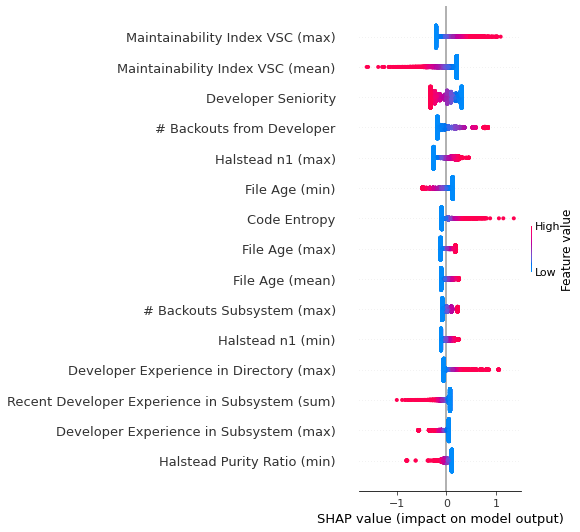

In [24]:
import shap
kind = 'bugbug_traditional'

X, y, f = datas[kind]
pipeline, t = pipelines[kind]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

clf = pipeline['model']
if 'traditional' in kind:
    X_ = pipeline['scaler'].transform(X_test)
    f = f.drop('target', axis=1)
    feature_names = [feature_name_map[c] for c in f.columns]
else:
    X_ = X_test.toarray()
    feature_names = f

explainer = shap.Explainer(clf, X_, feature_names=feature_names)
print(explainer)
shap_values = explainer.shap_values(X_)

shap.summary_plot(shap_values, X_, max_display=15, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig(f'experiments/plots_interpretability/summary_{kind}.pdf')

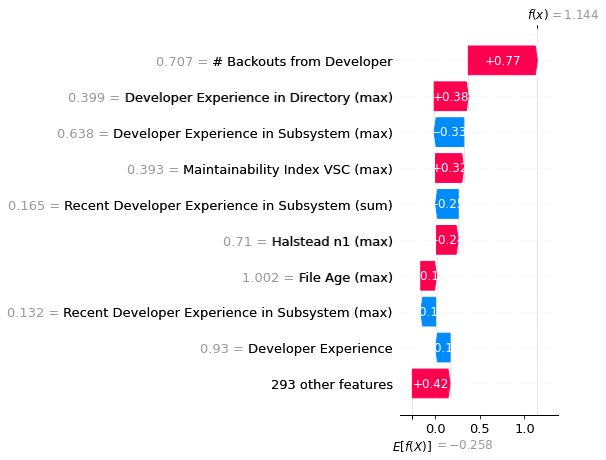

In [25]:
commitlevel_ix = 90291
buglevel_ix = 61674
ix = buglevel_ix if 'bugbug' in kind else commitlevel_ix

x = X_[[ix - X_train.shape[0]],:]

explainer = shap.Explainer(clf, X_, feature_names=feature_names)
shap_values = explainer(x)
plt.ioff()
shap.waterfall_plot(shap_values[0], show=False)
#plt.gcf()
plt.tight_layout()
plt.savefig(f'experiments/plots_interpretability/waterfall_{kind}.pdf')

In [ ]:
shap.initjs()

X_rus = RandomUnderSampler(random_state=0).fit_resample(X_, y_test)[0]
explainer = shap.KernelExplainer(clf.decision_function, X_rus, feature_names=feature_names, link='logit')
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0,:], x, feature_names=feature_names)

#### Finding candidate commit for investigation

In [13]:
F_buglevel = pd.read_csv('data/feature_extractor/features_buglevel.csv')
F_commitlevel = pd.read_csv('data/feature_extractor/features_commitlevel.csv')

rev_to_commitlevel_ix = {rev: i for i, rev in enumerate(F_commitlevel['revision'])}
commitlevel_ix_to_rev = list(F_commitlevel['revision'])

rev_to_buglevel_ix = {}
buglevel_ix_to_rev = list(F_buglevel['revisions'])
for i, row in F_buglevel[['first_revision', 'revisions']].iterrows():
    first_rev = row['first_revision']
    revs = row['revisions']
    #print(i, first_rev, revs)
    for rev in revs.split(','):
        rev_to_buglevel_ix[rev] = i

del F_buglevel; del F_commitlevel

In [14]:
len(rev_to_commitlevel_ix), len(commitlevel_ix_to_rev), len(rev_to_buglevel_ix), len(buglevel_ix_to_rev)

(99694, 99694, 99694, 67921)

In [15]:
szz_tps = read_data_from_json('experiments/results/szz_regressed_by_tp.json')

In [16]:
szz_tps_buglevel_ix = []
szz_tps_commitlevel_ix = []

for rev in szz_tps:
    try:
        szz_tps_buglevel_ix.append(rev_to_buglevel_ix[rev])
    except KeyError:
        pass
    try:
        szz_tps_commitlevel_ix.append(rev_to_commitlevel_ix[rev])
    except KeyError:
        pass
    
szz_tps_buglevel_ix = sorted(list(set(szz_tps_buglevel_ix)))
szz_tps_commitlevel_ix = sorted(list(set(szz_tps_commitlevel_ix)))
len(szz_tps_buglevel_ix), len(szz_tps_commitlevel_ix)

(103, 125)

In [17]:
kind = 'szz'
szz_tps_ixs = szz_tps_commitlevel_ix if kind == 'szz' else szz_tps_buglevel_ix
szz_tps_ixs = np.array(szz_tps_ixs)

X, y, _ = datas[kind + '_traditional']
clf, t = pipelines[kind + '_traditional']
y_pred_traditional = predict_at_threshold(clf, X[szz_tps_ixs, :], t)

print(y[szz_tps_ixs].sum(), len(szz_tps_ixs))

X, y, _ = datas[kind + '_bow']
clf, t = pipelines[kind + '_bow']
y_pred_bow = predict_at_threshold(clf, X[szz_tps_ixs, :], t)

y_pred_traditional.sum(), y_pred_bow.sum()

125 125


(3, 48)

In [18]:
test_threshold = X.shape[0] * 0.9
disagreements = szz_tps_ixs[(y_pred_traditional < y_pred_bow)]
disagreements[disagreements > test_threshold]

array([90291])

In [19]:
commit_ix = 90291
rev = commitlevel_ix_to_rev[commit_ix]
bug_ix = rev_to_buglevel_ix[rev]
rev, bug_ix, buglevel_ix_to_rev[bug_ix]

('9ac290ec5884fd52bb6c16e9794da5b42f211cbb',
 61674,
 '9d579691527b18c375569ac395b49e7ed3e21e0a,92e9abe2b2ad6eb513e806acd411470f4a767040,12f2689105713966aa58ac36ba4975ae93636f79,9ac290ec5884fd52bb6c16e9794da5b42f211cbb')

In [23]:
kind = 'bugbug_reg'
ix = bug_ix if 'bugbug' in kind else commit_ix

X, y, _ = datas[kind + '_traditional']
clf, t = pipelines[kind + '_traditional']
y_pred_traditional = predict_at_threshold(clf, X[[ix], :], t)

X, y, _ = datas[kind + '_bow']
clf, t = pipelines[kind + '_bow']
y_pred_bow = predict_at_threshold(clf, X[[ix], :], t)

y_pred_traditional[0], y_pred_bow[0]

(1, 1)